# Acinetobacter baumannii mass spectrometry data mapping

Using multiple metabolite databases to elucidate structures obtained with mass spectrometry. Data was obtained from " Untargeted metabolomics analysis reveals key pathways responsible for the synergistic killing of colistin and doripenem combination against Acinetobacter baumannii".

In [39]:
# Importing packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string

# COBRA toolbox specific packages
from cobra import Model, Reaction, Metabolite
import cobra
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [40]:
# Loading mass spec. data into dataframe
df_AB_mass_spec_data = pd.read_csv("Acinetobacter_baumannii_mass_spec.csv")
df_AB_mass_spec_data_important_features = df_AB_mass_spec_data.loc[:, 'Mass':'Max intensity'] # extracting important features
# df_AB_mass_spec_data_important_features.head()

df_AB_mass_spec_minimal = df_AB_mass_spec_data_important_features[['Mass','Formula','Putative metabolite']] # Mass, formula, name
df_AB_mass_spec_minimal.head()

,Mass,Formula,Putative metabolite
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate
1,147.052987,C5H9NO4,L-Glutamate
2,175.095627,C6H13N3O3,L-Citrulline
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate


# A. baumannii network reconstruction
From "Updated and standardized genome-scale reconstruction of Mycobacterium tuberculosis H37Rv, iEK1011, simulates flux states indicative of physiological conditions"

In [41]:
# Loading Acinetobacter baumannii network reconstruction 'iCN718'
AB_model=cobra.io.load_json_model('iCN718.json');

# Mass calculator 

In [42]:
# Writing function that calculates molar mass from chemical formula
def calc_mass_from_formula( formula ):
    
    # Typical mass of compounds --- assumes non-monoisotopic
    C = 12.0107 # +/- 0.0008
    H = 1.00794 # +/- 0.00001
    N = 14.0067 # +/- 0.0001
    O = 15.9994 # +/-
    P = 30.973762 # +/- 0.000002
    S =  32.065 # +/- 0.005

    # Initializing new string for first round of alteration (i.e., adding the '+')
    new_str = ''

    # Adding a '+' before every element
    for index in range (0, len(formula)):
        temp_str = formula[index]
        if temp_str.isalpha():
            new_str = new_str + '+' + temp_str 
        elif temp_str.isnumeric():
            new_str = new_str + temp_str
            
    # Removing the '+' at teh beginning of each string
    if new_str[0] == '+':
        str_formula_add = new_str[1:]

    # Initializing new string for second round of alteration (i.e., adding the '*')
    final_str_formula = ''

    # Adding a '*' after each element that is followed by a number
    for index in range(0,len(str_formula_add)):
        temp_str_1 = str_formula_add[index]
        if index != len(str_formula_add)-1:
            temp_str_2 = str_formula_add[index + 1]
        if temp_str_1.isalpha() and temp_str_2.isnumeric():
            final_str_formula = final_str_formula + temp_str_1 + '*'
        else: 
            final_str_formula = final_str_formula + temp_str_1

    # Evaludating string expression and returning molecular mass to user
    molecular_mass = eval(final_str_formula)    
    return molecular_mass



In [44]:
# Test case of function (output should be 189.1659 )
mass = calc_mass_from_formula('C7H11NO5')
print(mass)

189.16593999999998


# Parsing A. baumannii - specific database (from biocyc)


In [38]:
# Parsing data A_Baumannii file containing compounds

with open('A_Baumannii_compounds.txt') as f:
    # counter = 0
    # common_name = []
    # inchi = []
    # mono_mw = []
    start = False
    compounds = []
    for line in f:
        if line.strip().split()[0] =='UNIQUE-ID':
            start = True
            compound = {'COMMON-NAME':'','INCHI':'', 'MONOISOTOPIC-MW':0}
        if line.strip() == '//':
            start = False
            compounds.append(list(compound.values()))
        if start:
            line = line.strip().split()
            if line[0] == 'COMMON-NAME':
                compound['COMMON-NAME'] = ''.join(line[2:])
            if line[0] == 'INCHI':
                compound['INCHI'] = line[2].split('/')[1]
            if line[0] == 'MONOISOTOPIC-MW':
                compound['MONOISOTOPIC-MW'] = line[2]
    print(len(compounds))                    
    print(compounds[0])

1216
['C11H12Cl2N2O5', 'chloramphenicol', '322.0123269261']


In [36]:
compounds


[['C11H12Cl2N2O5', 'chloramphenicol', '322.0123269261'],
 ['C100H182N2O38P2',
  'KDO<SUB>2</SUB>-(palmitoleoyl)-lipidIV<SUB>A</SUB>',
  '2081.1845825124'],
 ['CHNO', 'cyanate', '43.0058136594'],
 ['C8H8O3', '4-hydroxyphenylacetate', '152.0473441231'],
 ['C34H52N7O20P3S',
  '3-[(3a<i>S</i>,4<i>S</i>,5<i>R</i>,7a<i>S</i>)-5-hydroxy-7a-methyl-1-oxo-octahydro-1<i>H</i>-inden-4-yl]-3-oxopropanoyl-CoA',
  '1003.2200673676001'],
 ['C34H54N7O20P3S',
  '3-[(3a<i>S</i>,4<i>S</i>,5<i>R</i>,7a<i>S</i>)-5-hydroxy-7a-methyl-1-oxo-octahydro-1<i>H</i>-inden-4-yl]-3-hydroxypropanoyl-CoA',
  '1005.2357174318'],
 ['C32H44N7O20P3S', 'benzoylsuccinyl-CoA', '971.1574671108'],
 ['C32H46N7O20P3S',
  '2-carboxymethyl-3-hydroxyphenylpropionyl-CoA',
  '973.1731171749999'],
 ['H2O', 'H<sub>2</sub>O', '18.0105646863'],
 ['C30H42N7O19P3S', '4-hydroxybenzoyl-acetyl-CoA', '929.1469024244999'],
 ['C30H44N7O19P3S',
  '3-(4-hydroxyphenyl)-3-hydroxy-propionyl-CoA',
  '931.1625524887'],
 ['CO2', 'CO<SUB>2</SUB>', '43.9898

In [22]:
# Create new dataframe for comparison
df_AB_mass_spec_mapping = df_AB_mass_spec_minimal.copy()
df_AB_mass_spec_mapping['mapped_MW'] = ''
df_AB_mass_spec_mapping['mapped_formula'] = ''
df_AB_mass_spec_mapping['mapped_metabs'] = ''

df_AB_mass_spec_mapping

# df_AB_mass_spec_mapping.loc[1,'mapped_MW'] = 'test'
# df_AB_mass_spec_mapping

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,,,
1,147.052987,C5H9NO4,L-Glutamate,,,
2,175.095627,C6H13N3O3,L-Citrulline,,,
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,,,
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,,,
5,115.063317,C5H9NO2,L-Proline,,,
6,131.094586,C6H13NO2,L-Leucine,,,
7,117.078934,C5H11NO2,L-Valine,,,
8,105.042676,C3H7NO3,L-Serine,,,
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,,,


In [45]:
# List of candidates 
# ppm = mass error / exact mass * 10^6

counter = 0

for mass_measured in df_AB_mass_spec_mapping['Mass']:
    candidate_metabs_mass = []
    candidate_metabs_formula = []
    candidate_metabs_name = []
    for compound in compounds:
        
        candidate_mass = compound[2]
        candidate_formula = compound[0]
        candidate_name = compound[1]
        
        if float(candidate_mass) > 0.1:
            error_ppm =  (abs((float(candidate_mass) - mass_measured)) / float(candidate_mass)) * (10**6)
        else:
            error_ppm = 1000000
        
        # Applying 5ppm error threshold 
        if error_ppm < 25:
            candidate_metabs_mass.append(candidate_mass)
            candidate_metabs_formula.append(candidate_formula)
            candidate_metabs_name.append(candidate_name)
            # print('got one') - verification that threshold is working to work
            
    candidate_metabs_mass_comb = ', '.join(map(str,candidate_metabs_mass))
    candidate_metabs_formula_comb = ', '.join(map(str,candidate_metabs_formula))
    candidate_metabs_name_comb = ', '.join(map(str,candidate_metabs_name))
    
#     if len(candidate_metabs_mass_comb) > 2:
#         test =candidate_metabs_mass
    
    df_AB_mass_spec_mapping.loc[counter,'mapped_MW'] = candidate_metabs_mass_comb
    df_AB_mass_spec_mapping.loc[counter,'mapped_formula'] = candidate_metabs_formula_comb
    df_AB_mass_spec_mapping.loc[counter,'mapped_metabs'] = candidate_metabs_name_comb
    
    counter += 1


# Displaying mapped dataframe
df_AB_mass_spec_mapping   

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,"189.0637224688, 189.0637224688","C7H11NO5, C7H11NO5","L-&alpha;-amino-&epsilon;-keto-pimelate, <i>N<..."
1,147.052987,C5H9NO4,L-Glutamate,"147.0531577825, 147.0531577825, 147.0531577825...","C5H9NO4, C5H9NO4, C5H9NO4, C5H9NO4, C5H9NO4","<i>O</i>-acetyl-L-serine, L-glutamate, D-gluta..."
2,175.095627,C6H13N3O3,L-Citrulline,175.0956912992,C6H13N3O3,L-citrulline
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,"221.0899372193, 221.0899372193","C8H15NO6, C8H15NO6","<i>N</i>-acetyl-&beta;-D-glucosamine, <i>N</i>..."
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,"259.0457029414, 259.0457029414","C6H14NO8P, C6H14NO8P","D-glucosamine1-phosphate, glycerophosphoserine"
5,115.063317,C5H9NO2,L-Proline,"115.0633285383, 115.0633285383","C5H9NO2, C5H9NO2","L-proline, D-proline"
6,131.094586,C6H13NO2,L-Leucine,"131.0946286667, 131.0946286667","C6H13NO2, C6H13NO2","L-leucine, L-isoleucine"
7,117.078934,C5H11NO2,L-Valine,"117.0789786025, 117.0789786025","C5H11NO2, C5H11NO2","5-aminopentanoate, L-valine"
8,105.042676,C3H7NO3,L-Serine,"105.0425930962, 105.0425930962","C3H7NO3, C3H7NO3","L-serine, D-serine"
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,384.1215884737,C14H20N6O5S,<i>S</i>-adenosyl-L-homocysteine


In [46]:
# Creating list with number of mapped matches

metab_matches = []

for mapped_metab in df_AB_mass_spec_mapping['mapped_metabs']:
    # print(mapped_metab)
    if len(mapped_metab) == 0:
        metab_matches.append(len(mapped_metab))
    else: 
        temp_metabs = mapped_metab.split(', ')
        temp_matches = len(temp_metabs)
        metab_matches.append(temp_matches)

In [48]:
metab_matches.count(0)

1327

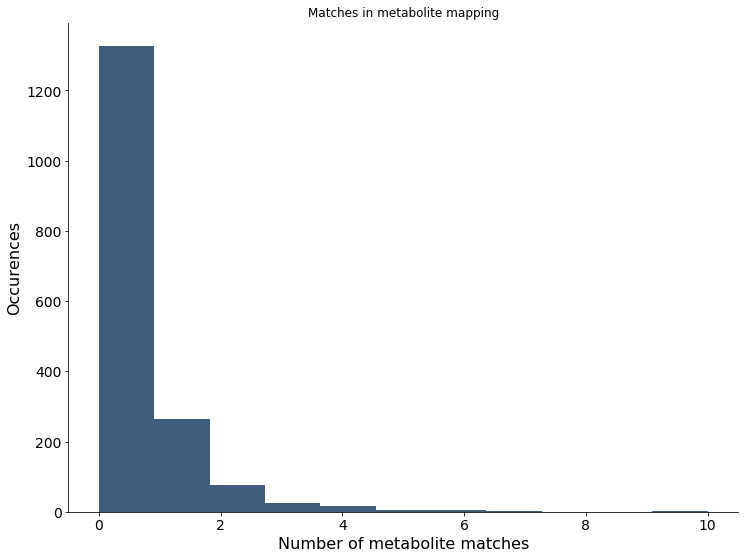

In [49]:
plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(fontsize=14)  
plt.yticks(range(0, 1347, 200), fontsize=14) 

plt.xlabel("Number of metabolite matches", fontsize=16)  
plt.ylabel("Occurences", fontsize=16)

plt.title('Matches in metabolite mapping')

plt.hist(metab_matches,  
         color="#3F5D7D", bins=11) 

plt.show()

In [50]:
# Bring 0-matches value down --- look for databases on KEGG and HMDB

LCMS_meausred_masses = df_AB_mass_spec_mapping['Mass']
type(LCMS_meausred_masses)
LCMS_meausred_masses.to_csv('LCMS_meausred_masses.csv')

# Using MetCyc database

In [51]:
# Parsing data A_Baumannii file containing compounds

with open('compounds.dat') as f:
    # counter = 0
    # common_name = []
    # inchi = []
    # mono_mw = []
    start = False
    compounds_MC = []
    for line in f:
        if line.strip().split()[0] =='UNIQUE-ID':
            start = True
            compound_MC = {'COMMON-NAME':'','INCHI':'', 'MONOISOTOPIC-MW':0}
        if line.strip() == '//':
            start = False
            compounds_MC.append(list(compound_MC.values()))
        if start:
            line = line.strip().split()
            if line[0] == 'COMMON-NAME':
                compound_MC['COMMON-NAME'] = ''.join(line[2:])
            if line[0] == 'INCHI':
                compound_MC['INCHI'] = line[2].split('/')[1]
            if line[0] == 'MONOISOTOPIC-MW':
                compound_MC['MONOISOTOPIC-MW'] = line[2]
    # print(len(compounds))                    
    # print(compounds[0])

In [55]:
compounds_MC

[['C6H4N2O5',
  'O-[5-(oxidonitroso)-4-oxocyclohex-2-en-1-ylidenenitroso]oxidanidolate',
  '186.02767131349998'],
 ['C6H3N3O7', '2,4,6-trinitrophenol', '232.02057456289998'],
 ['C6H3N3O7',
  'O-[3-nitro-5-(oxidonitroso)-4-oxocyclohex-2-en-1-ylidenenitroso]oxidanidolate',
  '232.02057456289998'],
 ['C9H8I2O4', 'diiodo-4-hydroxyphenyl-lactate', '433.8511947452'],
 ['C6H8N2O5', '2,4-dinitrocyclohexan-1-one', '190.05897144189998'],
 ['C9H6I2O4', 'diiodo-4-hydroxyphenylpyruvate', '431.835544681'],
 ['C6H4N2O5', '2,4-dinitrophenol', '186.02767131349998'],
 ['C9H12IN2O8P', "5-iodo-2'-dUMP", '433.9375948824'],
 ['C6H5N3O7',
  'O-[5-(hydroxynitroso)-3-(oxidonitroso)-2-oxocyclohexylidenenitroso]oxidanidolate',
  '234.0362246271'],
 ['C14H15IN2O4S',
  '5-((2-iodoacetamido)ethyl)-1-aminonapthalenesulfate',
  '433.9797206703'],
 ['C6H5N3O7',
  'O-[5-nitro-3-(oxidonitroso)-2-oxocyclohexylidenenitroso]oxidanidolate',
  '234.0362246271'],
 ['C14H10I2O4',
  '4-(4-hydroxyphenoxy)-3,5-diiodophenylacetate

In [52]:
# Create new dataframe for comparison
df_AB_mass_spec_mapping_MC = df_AB_mass_spec_minimal.copy()
df_AB_mass_spec_mapping_MC['mapped_MW'] = ''
df_AB_mass_spec_mapping_MC['mapped_formula'] = ''
df_AB_mass_spec_mapping_MC['mapped_metabs'] = ''

df_AB_mass_spec_mapping_MC

# df_AB_mass_spec_mapping.loc[1,'mapped_MW'] = 'test'
# df_AB_mass_spec_mapping

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,,,
1,147.052987,C5H9NO4,L-Glutamate,,,
2,175.095627,C6H13N3O3,L-Citrulline,,,
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,,,
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,,,
5,115.063317,C5H9NO2,L-Proline,,,
6,131.094586,C6H13NO2,L-Leucine,,,
7,117.078934,C5H11NO2,L-Valine,,,
8,105.042676,C3H7NO3,L-Serine,,,
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,,,


In [56]:
# List of candidates 
# ppm = mass error / exact mass * 10^6

counter = 0

for mass_measured_MC in df_AB_mass_spec_mapping_MC['Mass']:
    candidate_metabs_mass_MC = []
    candidate_metabs_formula_MC = []
    candidate_metabs_name_MC = []
    for compound_MC in compounds_MC:
        
        candidate_mass_MC = compound_MC[2]
        candidate_formula_MC = compound_MC[0]
        candidate_name_MC = compound_MC[1]
        
        if float(candidate_mass_MC) > 0.1:
            error_ppm =  (abs((float(candidate_mass_MC) - mass_measured_MC)) / float(candidate_mass_MC)) * (10**6)
        else:
            error_ppm = 1000000
        
        # Applying 5ppm error threshold 
        if error_ppm < 25:
            candidate_metabs_mass_MC.append(candidate_mass_MC)
            candidate_metabs_formula_MC.append(candidate_formula_MC)
            candidate_metabs_name_MC.append(candidate_name_MC)
            # print('got one') - verification that threshold is working to work
            
    candidate_metabs_mass_comb_MC = ', '.join(map(str,candidate_metabs_mass_MC))
    candidate_metabs_formula_comb_MC = ', '.join(map(str,candidate_metabs_formula_MC))
    candidate_metabs_name_comb_MC = ', '.join(map(str,candidate_metabs_name_MC))
    
#     if len(candidate_metabs_mass_comb) > 2:
#         test =candidate_metabs_mass
    
    df_AB_mass_spec_mapping_MC.loc[counter,'mapped_MW'] = candidate_metabs_mass_comb_MC
    df_AB_mass_spec_mapping_MC.loc[counter,'mapped_formula'] = candidate_metabs_formula_comb_MC
    df_AB_mass_spec_mapping_MC.loc[counter,'mapped_metabs'] = candidate_metabs_name_comb_MC
    
    counter += 1


# Displaying mapped dataframe
df_AB_mass_spec_mapping_MC

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,189.0637224688,C7H11NO5,<i>N</i>-acetyl-L-glutamate
1,147.052987,C5H9NO4,L-Glutamate,"147.0531577825, 147.0531577825","C5H9NO4, C5H9NO4","<i>N</i>-acetyl-L-serine, N-hydroxy-N-isopropy..."
2,175.095627,C6H13N3O3,L-Citrulline,175.0997140446,C11H13NO,"4-<i>trans</i>-(<i>N,N</i>-dimethylamino)cinna..."
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,"221.092617294, 221.092617294, 221.092617294, 2...","C11H12N2O3, C11H12N2O3, C11H12N2O3, C11H12N2O3...","9-<i>N</i>-hydroxy-L-tryptophan, (S)-&beta;-hy..."
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,259.0410512889,C4H9.Hg,<i>sec</i>-butylmercury
5,115.063317,C5H9NO2,L-Proline,115.0633285383,C5H9NO2,3-acetamidopropanal
6,131.094586,C6H13NO2,L-Leucine,"131.0946286667, 131.0946286667","C6H13NO2, C6H13NO2","<i>N</i>-(3-hydroxybutan-2-yl)acetamide, 2-mor..."
7,117.078934,C5H11NO2,L-Valine,,,
8,105.042676,C3H7NO3,L-Serine,,,
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,"384.1267762356, 384.12090299669995, 384.126776...","C14H24O12, C21H20O7, C14H24O12, C21H20O7, C14H...",6-<i>O</i>-acetyl-&alpha;-D-glucopyranosyl-(1&...


In [57]:
# Creating list with number of mapped matches

metab_matches_MC = []

for mapped_metab_MC in df_AB_mass_spec_mapping_MC['mapped_metabs']:
    # print(mapped_metab)
    if len(mapped_metab_MC) == 0:
        metab_matches_MC.append(len(mapped_metab_MC))
    else: 
        temp_metabs_MC = mapped_metab_MC.split(', ')
        temp_matches_MC = len(temp_metabs_MC)
        metab_matches_MC.append(temp_matches_MC)

In [58]:
metab_matches_MC.index(74)
df_AB_mass_spec_mapping_MC.loc[118, "mapped_metabs"]

'&beta;-L-idopyranose, &beta;-D-galactofuranose, &alpha;-D-galactofuranose, D-hamamelose, theophylline, D-fuconate, &alpha;-D-mannopyranose, L-rhamnonate, 2-deoxygluconate, &beta;-D-mannopyranose, L-glucose, &beta;-L-mannose, &alpha;-L-mannose, theobromine, paraxanthine, L-fuconate, &beta;-L-fructofuranose, &alpha;-L-fructofuranose, &alpha;-L-galactose, &beta;-L-fructopyranose, &alpha;-L-fructopyranose, &beta;-D-fructopyranose, &alpha;-D-fructopyranose, &alpha;-D-talose, L-<i>xylo</i>-3-hexulose, &beta;-L-galactose, <i>scyllo</i>-inositol, 1D-<i>chiro</i>-inositol, <i>aldehydo</i>-D-mannose, <i>aldehydo</i>-D-glucose, <i>keto</i>-D-tagatose, <i>keto</i>-D-psicose, <i>keto</i>-D-sorbose, &alpha;-D-fructofuranose, <i>keto</i>-D-fructose, <i>aldehydo</i>-L-mannose, &beta;-D-fructofuranose, &alpha;-D-galactose, &beta;-D-galactose, <I>myo</I>-inositol, <i>aldehydo</i>-D-galactose, <i>keto</i>-L-sorbose, <i>aldehydo</i>-D-gulose, &alpha;-D-gulose, &beta;-D-gulose, &alpha;-L-gulose, &beta;-L-

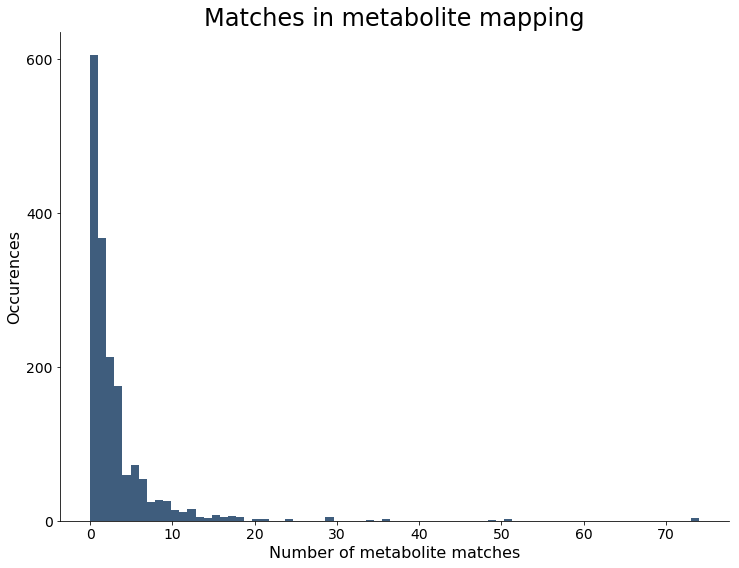

In [59]:
plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(fontsize=14)  
plt.yticks(range(0, 650, 200), fontsize=14) 

plt.xlabel("Number of metabolite matches", fontsize=16)  
plt.ylabel("Occurences", fontsize=16)

plt.title('Matches in metabolite mapping', fontsize=24)

plt.hist(metab_matches_MC,  
         color="#3F5D7D",bins = 75) 

plt.show()

# BioCyc + MetCyc

In [175]:
compounds_mixed = compounds + compounds_MC

compounds_mixed

[['322.0123269261', 'chloramphenicol', 'C11H12Cl2N2O5'],
 ['2081.1845825124',
  'KDO<SUB>2</SUB>-(palmitoleoyl)-lipidIV<SUB>A</SUB>',
  'C100H182N2O38P2'],
 ['43.0058136594', 'cyanate', 'CHNO'],
 ['152.0473441231', '4-hydroxyphenylacetate', 'C8H8O3'],
 ['1003.2200673676001',
  '3-[(3a<i>S</i>,4<i>S</i>,5<i>R</i>,7a<i>S</i>)-5-hydroxy-7a-methyl-1-oxo-octahydro-1<i>H</i>-inden-4-yl]-3-oxopropanoyl-CoA',
  'C34H52N7O20P3S'],
 ['1005.2357174318',
  '3-[(3a<i>S</i>,4<i>S</i>,5<i>R</i>,7a<i>S</i>)-5-hydroxy-7a-methyl-1-oxo-octahydro-1<i>H</i>-inden-4-yl]-3-hydroxypropanoyl-CoA',
  'C34H54N7O20P3S'],
 ['971.1574671108', 'benzoylsuccinyl-CoA', 'C32H44N7O20P3S'],
 ['973.1731171749999',
  '2-carboxymethyl-3-hydroxyphenylpropionyl-CoA',
  'C32H46N7O20P3S'],
 ['18.0105646863', 'H<sub>2</sub>O', 'H2O'],
 ['929.1469024244999', '4-hydroxybenzoyl-acetyl-CoA', 'C30H42N7O19P3S'],
 ['931.1625524887',
  '3-(4-hydroxyphenyl)-3-hydroxy-propionyl-CoA',
  'C30H44N7O19P3S'],
 ['43.989829244199996', 'CO<SUB>2</

In [174]:
compounds == compounds_MC

False

In [176]:
# Create new dataframe for comparison
df_AB_mass_spec_mapping_mixed = df_AB_mass_spec_minimal.copy()
df_AB_mass_spec_mapping_mixed['mapped_MW'] = ''
df_AB_mass_spec_mapping_mixed['mapped_formula'] = ''
df_AB_mass_spec_mapping_mixed['mapped_metabs'] = ''

df_AB_mass_spec_mapping_mixed

# df_AB_mass_spec_mapping.loc[1,'mapped_MW'] = 'test'
# df_AB_mass_spec_mapping

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,,,
1,147.052987,C5H9NO4,L-Glutamate,,,
2,175.095627,C6H13N3O3,L-Citrulline,,,
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,,,
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,,,
5,115.063317,C5H9NO2,L-Proline,,,
6,131.094586,C6H13NO2,L-Leucine,,,
7,117.078934,C5H11NO2,L-Valine,,,
8,105.042676,C3H7NO3,L-Serine,,,
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,,,


In [178]:
# List of candidates 
# ppm = mass error / exact mass * 10^6

counter = 0

for mass_measured_mixed in df_AB_mass_spec_mapping_mixed['Mass']:
    candidate_metabs_mass_mixed = []
    candidate_metabs_formula_mixed = []
    candidate_metabs_name_mixed = []
    for compound_mixed in compounds_mixed:
        
        candidate_mass_mixed = compound_mixed[0]
        candidate_formula_mixed = compound_mixed[1]
        candidate_name_mixed = compound_mixed[2]
        
        if float(candidate_mass_mixed) > 0.1:
            error_ppm =  (abs((float(candidate_mass_mixed) - mass_measured_mixed)) / float(candidate_mass_mixed)) * (10**6)
        else:
            error_ppm = 1000000
        
        # Applying 5ppm error threshold 
        if error_ppm < 25:
            candidate_metabs_mass_mixed.append(candidate_mass_mixed)
            candidate_metabs_formula_mixed.append(candidate_formula_mixed)
            candidate_metabs_name_mixed.append(candidate_name_mixed)
            # print('got one') - verification that threshold is working to work
            
    candidate_metabs_mass_comb_mixed = ', '.join(map(str,candidate_metabs_mass_mixed))
    candidate_metabs_formula_comb_mixed = ', '.join(map(str,candidate_metabs_formula_mixed))
    candidate_metabs_name_comb_mixed = ', '.join(map(str,candidate_metabs_name_mixed))
    
#     if len(candidate_metabs_mass_comb) > 2:
#         test =candidate_metabs_mass
    
    df_AB_mass_spec_mapping_mixed.loc[counter,'mapped_MW'] = candidate_metabs_mass_comb_mixed
    df_AB_mass_spec_mapping_mixed.loc[counter,'mapped_formula'] = candidate_metabs_formula_comb_mixed
    df_AB_mass_spec_mapping_mixed.loc[counter,'mapped_metabs'] = candidate_metabs_name_comb_mixed
    
    counter += 1


# Displaying mapped dataframe
df_AB_mass_spec_mapping_mixed

,Mass,Formula,Putative metabolite,mapped_MW,mapped_formula,mapped_metabs
0,189.063754,C7H11NO5,N-Acetyl-L-glutamate,"189.0637224688, 189.0637224688, 189.0637224688","L-&alpha;-amino-&epsilon;-keto-pimelate, <i>N<...","C7H11NO5, C7H11NO5, C7H11NO5"
1,147.052987,C5H9NO4,L-Glutamate,"147.0531577825, 147.0531577825, 147.0531577825...","<i>O</i>-acetyl-L-serine, L-glutamate, D-gluta...","C5H9NO4, C5H9NO4, C5H9NO4, C5H9NO4, C5H9NO4, C..."
2,175.095627,C6H13N3O3,L-Citrulline,"175.0956912992, 175.0997140446","L-citrulline, 4-<i>trans</i>-(<i>N,N</i>-dimet...","C6H13N3O3, C11H13NO"
3,221.089958,C8H15NO6,N-Acetyl-D-glucosamine,"221.0899372193, 221.0899372193, 221.092617294,...","<i>N</i>-acetyl-&beta;-D-glucosamine, <i>N</i>...","C8H15NO6, C8H15NO6, C11H12N2O3, C11H12N2O3, C1..."
4,259.045942,C6H14NO8P,D-Glucosamine 6-phosphate,"259.0457029414, 259.0457029414, 259.0410512889","D-glucosamine1-phosphate, glycerophosphoserine...","C6H14NO8P, C6H14NO8P, C4H9.Hg"
5,115.063317,C5H9NO2,L-Proline,"115.0633285383, 115.0633285383, 115.0633285383","L-proline, D-proline, 3-acetamidopropanal","C5H9NO2, C5H9NO2, C5H9NO2"
6,131.094586,C6H13NO2,L-Leucine,"131.0946286667, 131.0946286667, 131.0946286667...","L-leucine, L-isoleucine, <i>N</i>-(3-hydroxybu...","C6H13NO2, C6H13NO2, C6H13NO2, C6H13NO2"
7,117.078934,C5H11NO2,L-Valine,"117.0789786025, 117.0789786025","5-aminopentanoate, L-valine","C5H11NO2, C5H11NO2"
8,105.042676,C3H7NO3,L-Serine,"105.0425930962, 105.0425930962","L-serine, D-serine","C3H7NO3, C3H7NO3"
9,384.122018,C14H20N6O5S,S-Adenosyl-L-homocysteine,"384.1215884737, 384.1267762356, 384.1209029966...","<i>S</i>-adenosyl-L-homocysteine, 6-<i>O</i>-a...","C14H20N6O5S, C14H24O12, C21H20O7, C14H24O12, C..."


In [179]:
# Creating list with number of mapped matches

metab_matches_mixed = []

for mapped_metab_mixed in df_AB_mass_spec_mapping_mixed['mapped_metabs']:
    # print(mapped_metab)
    if len(mapped_metab_mixed) == 0:
        metab_matches_mixed.append(len(mapped_metab_mixed))
    else: 
        temp_metabs_mixed = mapped_metab_mixed.split(', ')
        temp_matches_mixed = len(temp_metabs_mixed)
        metab_matches_mixed.append(temp_matches_mixed)

In [180]:
max(metab_matches_mixed)

80

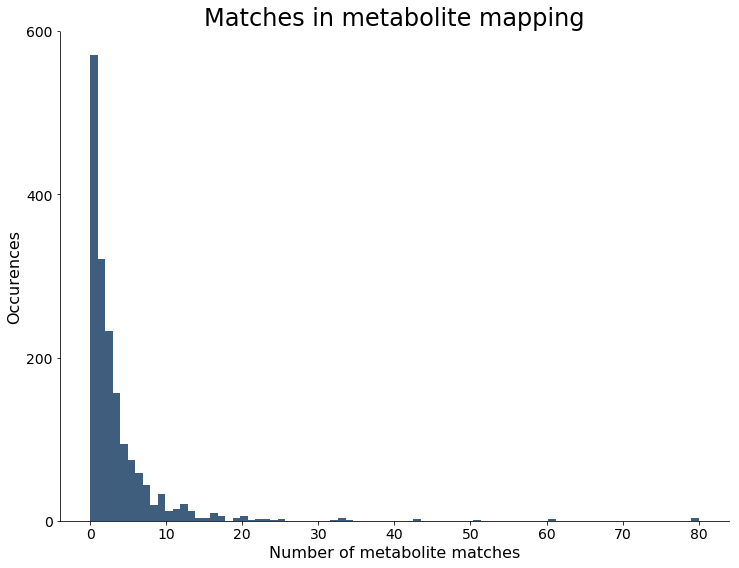

In [182]:
plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(fontsize=14)  
plt.yticks(range(0, 650, 200), fontsize=14) 

plt.xlabel("Number of metabolite matches", fontsize=16)  
plt.ylabel("Occurences", fontsize=16)

plt.title('Matches in metabolite mapping', fontsize=24)

plt.hist(metab_matches_mixed,  
         color="#3F5D7D",bins = 81) 

plt.show()

# Less 0 matches, but also less singular matches 

# Pathway determination 